# 6.6 Task Sourcing & Analyzing Time Series Data

### Script Contents:
### 1. Import Libraries & Data
### 2. Subsetting, Wrangling, & Cleaning Time-Series Data
### 3. Time-Series Analysis: Decomposition
### 4. Testing for Stationarity
### 5. Stationarizing the Zillow Real Estate Data

# 1. Import Libraries & Data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

%matplotlib inline

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'NQzJLnJZiUia77xG3TRw'

### Data set from data.nasdaq.com was downloaded and imported here
### Source: https://data.nasdaq.com/databases/ZILLOW

In [3]:
# assign path

path = r'C:\Users\X1\House Sales Analysis Master'

In [4]:
# Import Zillow Real Estate Data

data = pd.read_csv(os.path.join(path,'02 Data','Original Data','zillow_data.csv'), index_col = False)

In [13]:
data.head()

,date,value
0,1996-01-31,90318.0
1,1996-01-31,169960.0
2,1996-01-31,169804.0
3,1996-01-31,136243.0
4,1996-01-31,157893.0


In [6]:
data.columns

Index(['date', 'value'], dtype='object')

In [7]:
data.shape

(10000, 2)

In [8]:
type(data)

pandas.core.frame.DataFrame

In [9]:
data.isnull().sum()

date     0
value    0
dtype: int64

### The data set has too many houses sold each month to plot effectively.  
### Aggregate the data to find the monthly average.

In [16]:
data_avg = data.groupby('date').agg({'value': ['mean']})
data_avg.head(10)

,value
,mean
date,
1996-01-31,144105.857143
1996-02-29,144639.571429
1996-03-31,144922.000000
1996-04-30,145506.714286
1996-05-31,146361.571429
1996-06-30,147700.857143
1996-07-31,149652.571429
1996-08-31,151626.857143


In [17]:
data_avg.shape

(341, 1)

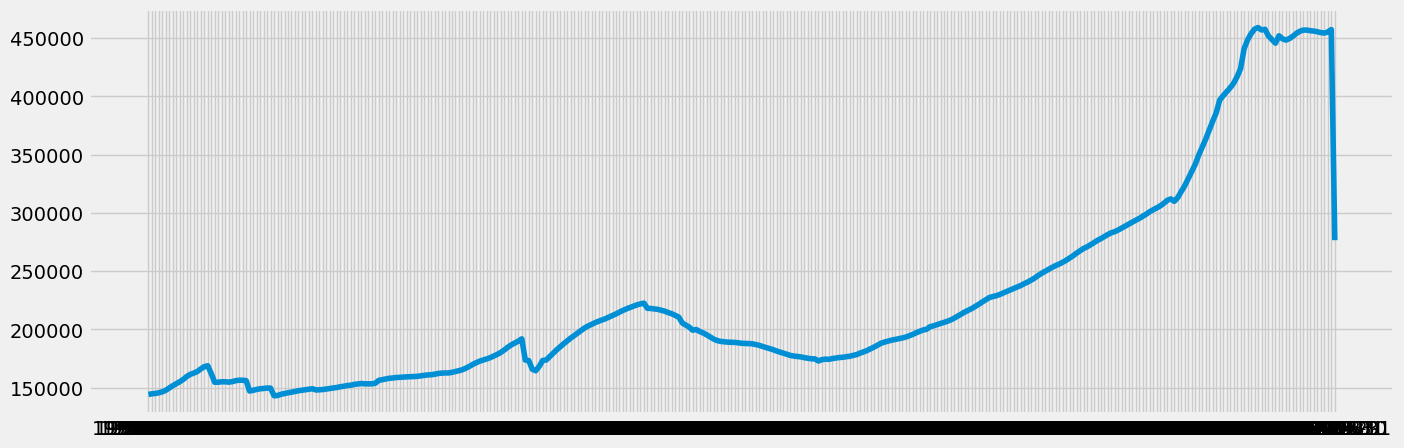

In [18]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 

plt.plot(data_avg)

# 2. Subsetting, Wrangling, & Cleaning Time-Series Data

In [20]:
data_avg.head()

,value
,mean
date,
1996-01-31,144105.857143
1996-02-29,144639.571429
1996-03-31,144922.000000
1996-04-30,145506.714286
1996-05-31,146361.571429


In [22]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data_avg.reset_index()

In [23]:
data_2.head()

,date,value
,,mean
0,1996-01-31,144105.857143
1,1996-02-29,144639.571429
2,1996-03-31,144922.000000
3,1996-04-30,145506.714286
4,1996-05-31,146361.571429


### Subsetting

In [24]:
# Only creating subset from 2014 to 2015 since that is what the original housing data set contains.

data_sub = data_2.loc[(data_2['date'] >= '2014-01-01') & (data_2['date'] <= '2015-12-31')]

In [25]:
data_sub.shape

(24, 2)

In [26]:
data_sub.head()

,date,value
,,mean
216,2014-01-31,192528.628143
217,2014-02-28,193280.463895
218,2014-03-31,194370.054372
219,2014-04-30,195529.851273
220,2014-05-31,196983.707927


In [27]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,value
,mean
datetime,
2014-01-31,192528.628143
2014-02-28,193280.463895
2014-03-31,194370.054372
2014-04-30,195529.851273
2014-05-31,196983.707927


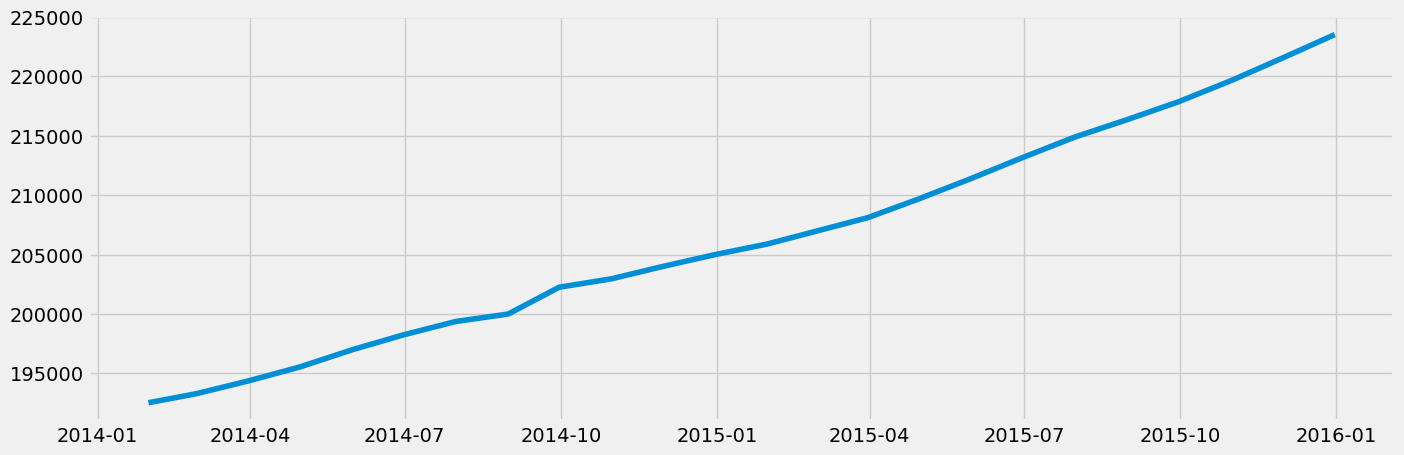

In [28]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

### - The original Seattle, Washington house prices data set I'm comparing from contained data from 2014 to 2015. 
### - The Zillow Real Estate Data line chart shows an upward trend, meaning the average price of houses in the United States grew about 16.8% in from 2014-2015.

In [29]:
# Check for missing values

data_sub.isnull().sum() 

value  mean    0
dtype: int64

In [32]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dupes

0

# 3. Time-Series Analysis: Decomposition

In [33]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [34]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

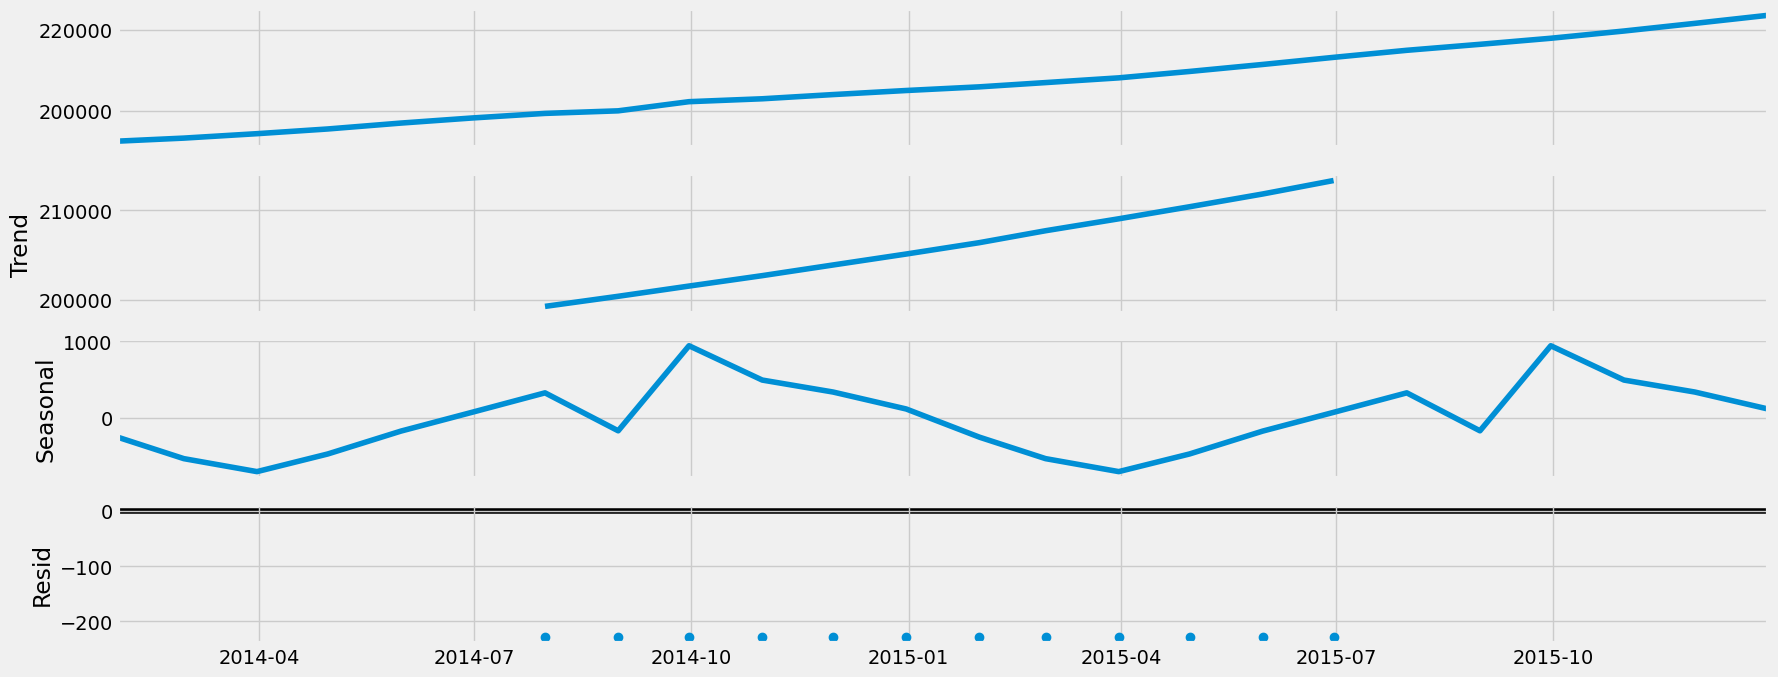

In [35]:
# Plot the separate components

decomposition.plot()
plt.show()

### - Comparing the level to the trend line, the dominant trend is upward over time; house prices increasing.
### - The seasonality line show a drop in prices around August and then increases greatly in September, followed by a slight decrease again from October throughout April, where it starts to increase again and repeats the drop in August. I would not rely on this data to select the right time to purchase a house, but the seasonality may prove useful.
### - The residual data is insignificant.

# 4. Testing for Stationarity

#### Conduct Dickey-Fuller Stationarity Test:

In [37]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series

dickey_fuller(data_sub['value'])

Dickey-Fuller Stationarity test:
Test Statistic                  1.995576
p-value                         0.998667
Number of Lags Used             4.000000
Number of Observations Used    19.000000
Critical Value (1%)            -3.832603
Critical Value (5%)            -3.031227
Critical Value (10%)           -2.655520
dtype: float64


### - Null hypothesis: House prices stay the same over time.
### - The p-value is 0.99, which is not significant.
### - Using the Critical Value (5%), -3.03, this is much smaller than the Test Statistic of 1.99, which means there is a unit root and the data is non-stationary.
### - The null hypothesis cannot be rejected.

# 5. Stationarizing the Zillow Real Estate Data

#### Conduct a round of diferencing 

In [38]:
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

data_diff = data_sub - data_sub.shift(1)

In [39]:
# Here, you remove the missing values that came about as a result of the differencing. 

data_diff.dropna(inplace = True) 

# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [40]:
data_diff.head()

,value
,mean
datetime,
2014-02-28,751.835752
2014-03-31,1089.590477
2014-04-30,1159.796900
2014-05-31,1453.856655
2014-06-30,1246.791418


In [41]:
data_diff.columns

MultiIndex([('value', 'mean')],
           )

#### Original Dickey-Fuller Stationarity test:

In [43]:
dickey_fuller(data_sub['value'])

Dickey-Fuller Stationarity test:
Test Statistic                  1.995576
p-value                         0.998667
Number of Lags Used             4.000000
Number of Observations Used    19.000000
Critical Value (1%)            -3.832603
Critical Value (5%)            -3.031227
Critical Value (10%)           -2.655520
dtype: float64


#### Post-round of differencing:

In [42]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -3.537710
p-value                         0.007070
Number of Lags Used             0.000000
Number of Observations Used    22.000000
Critical Value (1%)            -3.769733
Critical Value (5%)            -3.005426
Critical Value (10%)           -2.642501
dtype: float64


### - The p-value is much more significant at 0.007.
### - Test Statistic of -3.537 is smaller than Critial Value (5%) of -3.005, meaning we can reject the null hypothesis.


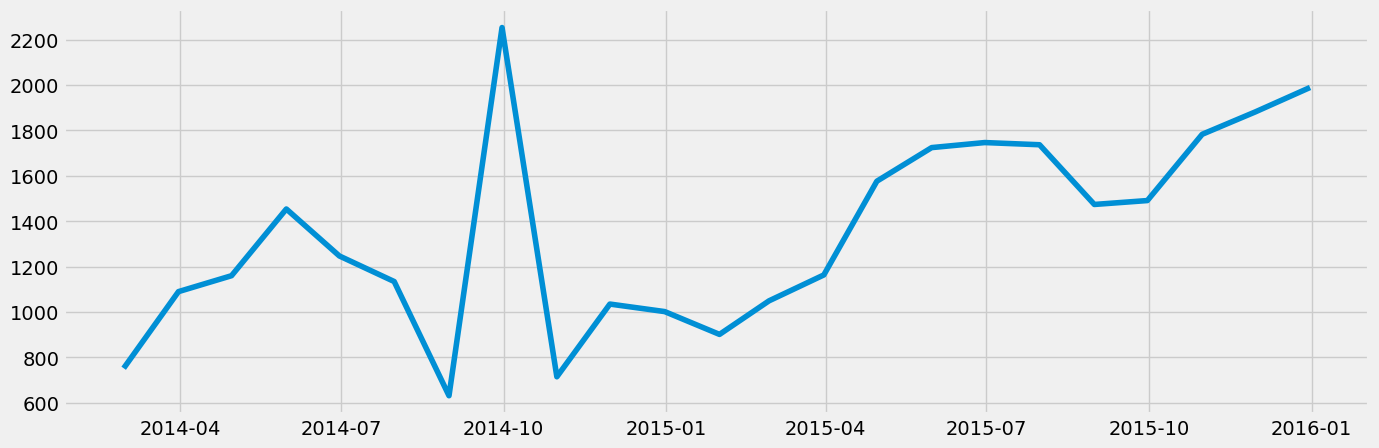

In [45]:
# Check out what the differencing did to the time-series curve.

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

### - After differencing the data, the line chart shows more drastic rises and falls since the trend was removed.

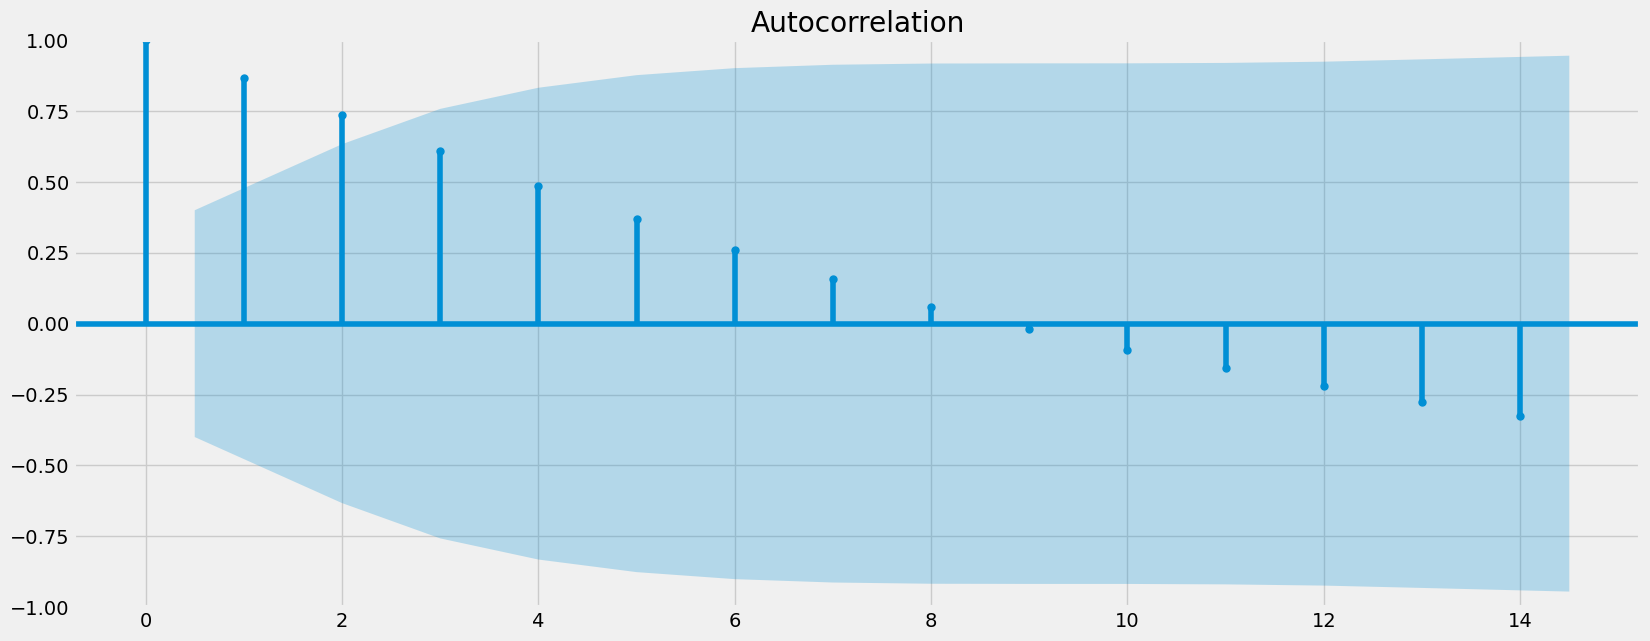

In [44]:
# Check out a plot of autocorrelations before differencing.

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

### - The verticle lines represent the lags. The blue area represents the confidence interval. 
### - The first three lines on the left show that the lags are significantly correlated with each other.
### - The data is non-stationary.

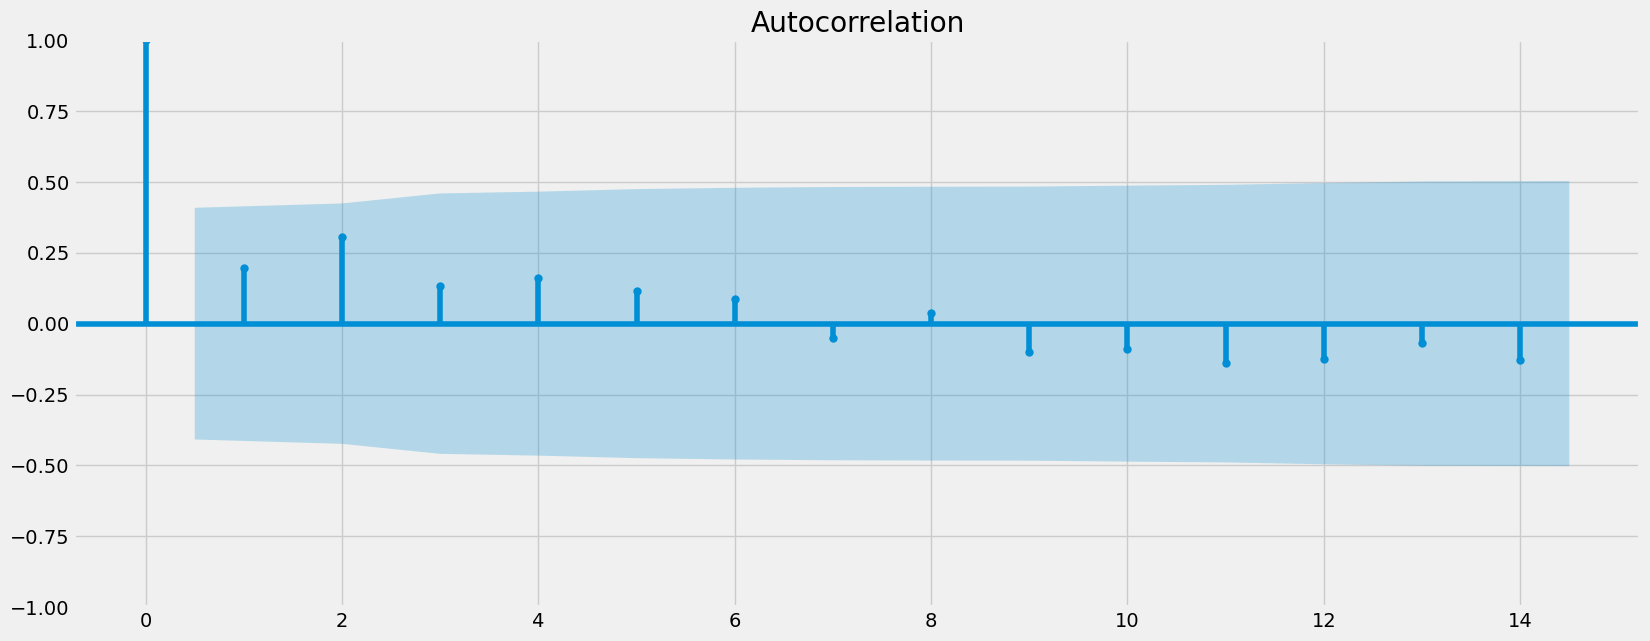

In [46]:
# Check autocorrelation after differencing.

plot_acf(data_diff)
plt.show()

### - After a round of differencing, the data is looking more stationary after the first blue vertical line.